# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 4

* env: 
    * fyp2026 (Python 3.11.11) 
    * fpytorch (Python 3.11.11)

In [1]:
# avoid OMP initialization error: 
# Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\fuy3pk\AppData\Local\Temp\ipykernel_25200\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

In [4]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms.v2 import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize, ToImage, ToDtype

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

# Classifying Images

## Data Generation

* 非对角线 - 值=0 - 负类
* 对角线 - 值=1 - 正类
* 图片像素： 5x5 --> 二维矩阵表示，`单通道`图像
* dtype = np.unit8 --> 只接受0-255的值

`Q: 二维相片单通道，和向量，矩阵和张量维数的区别`

二维相片的单通道和向量、矩阵、张量的维数之间的区别可以通过以下方式理解：

### 1. **二维相片单通道**
- **定义**: 二维相片的单通道是一个灰度图像，表示为一个二维矩阵，其中每个元素是像素的灰度值。
- **维数**: 它是一个二维数组，形状为 `(height, width)`，例如 `28x28` 的灰度图像。
- **特点**: 
  - 每个像素点的值通常在 `[0, 255]` 或 `[0, 1]` 范围内。
  - 单通道表示没有颜色信息，仅有亮度。

---

### 2. **向量**
- **定义**: 向量是一个一维数组，可以看作是一个具有方向和大小的数学对象。
- **维数**: 它是一个一维张量，形状为 `(n,)`，例如 `[1, 2, 3]` 是一个 3 维向量。
- **特点**:
  - 只有一个轴。
  - 用于表示数据点、权重等。

---

### 3. **矩阵**
- **定义**: 矩阵是一个二维数组，包含行和列。
- **维数**: 它是一个二维张量，形状为 `(rows, columns)`，例如 `3x3` 矩阵。
- **特点**:
  - 用于表示线性变换、图像数据等。
  - 每个元素可以是标量或其他对象。

---

### 4. **张量**
- **定义**: 张量是一个多维数组，可以是标量（0 维）、向量（1 维）、矩阵（2 维）或更高维度的数组。
- **维数**: 张量的维数由其轴数决定，例如：
  - 标量：0 维，形状 `()`。
  - 向量：1 维，形状 `(n,)`。
  - 矩阵：2 维，形状 `(rows, columns)`。
  - 高维张量：3 维或更多，例如 `(channels, height, width)` 表示彩色图像。
- **特点**:
  - 张量是深度学习中数据的基本表示形式。
  - 可以表示任意维度的数据。

---

### 区别总结
| **类型**       | **维数** | **形状示例**       | **用途**                     |
|----------------|----------|--------------------|------------------------------|
| 单通道相片     | 2D       | `(height, width)`  | 灰度图像                     |
| 向量           | 1D       | `(n,)`             | 数据点、权重                 |
| 矩阵           | 2D       | `(rows, columns)`  | 图像、线性变换               |
| 张量           | N 维     | `(d1, d2, ..., dn)`| 彩色图像、深度学习模型输入等 |

例如，彩色图像通常是一个 3D 张量，形状为 `(channels, height, width)`，其中 `channels=3` 表示 RGB 三个通道。

In [5]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

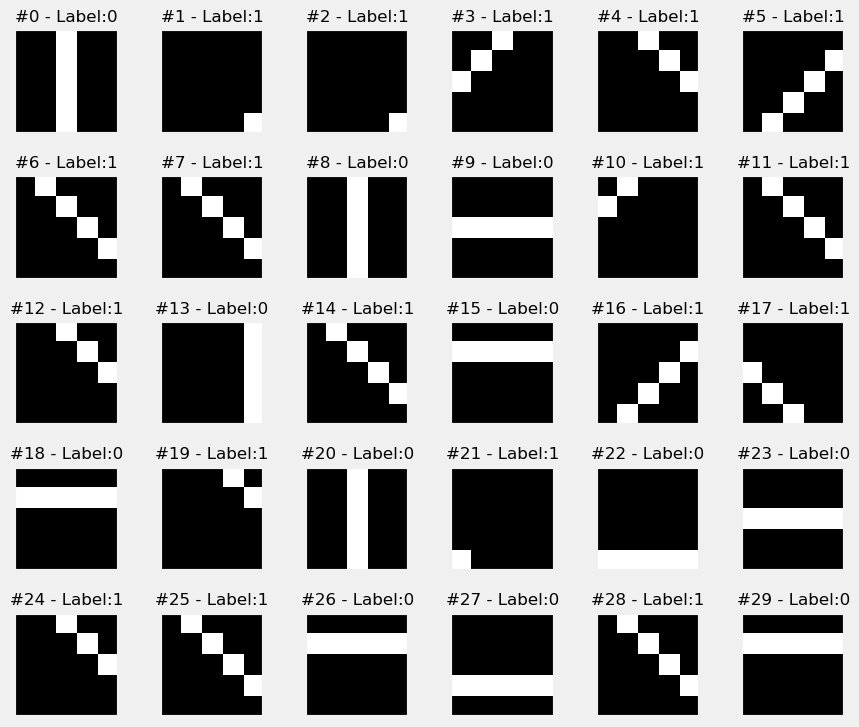

In [6]:
fig = plot_images(images, labels, n_plot=30)
fig

## Images and Channels

### a. 单通道图片

In [7]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

[[255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]]


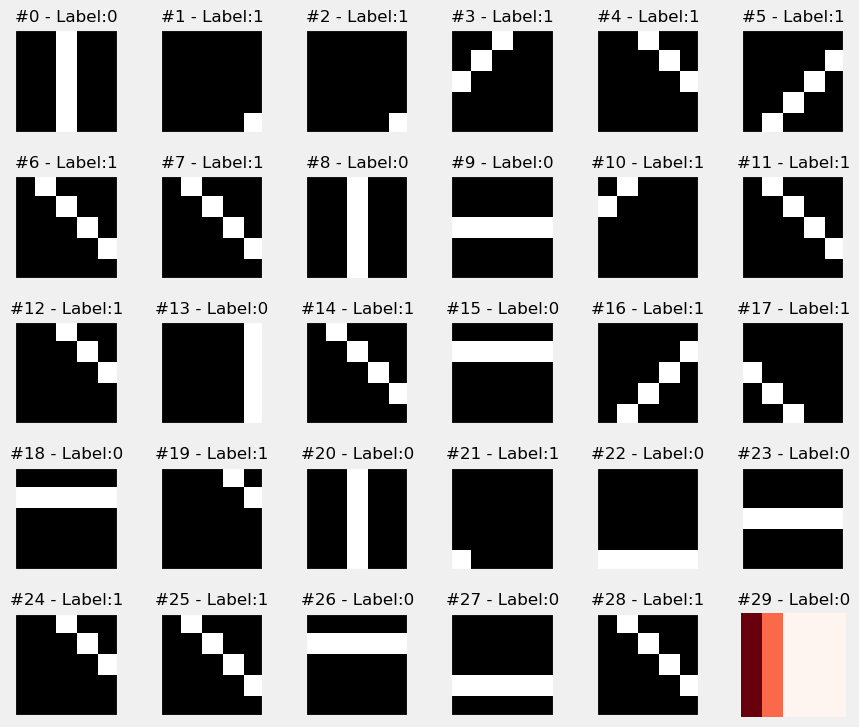

In [8]:
# define the image_r
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

print(image_r)

# show only image_r, cmap is red
plt.imshow(image_r, cmap='Reds', vmin=0, vmax=255)
#plt.imshow(image_r, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

[[  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]]


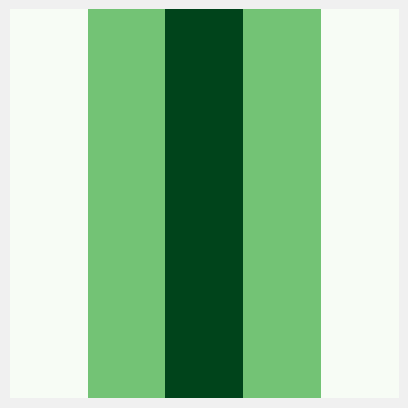

In [9]:
# define the image_g
image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

print(image_g)

# show only image_g
plt.imshow(image_g, cmap='Greens', vmin=0, vmax=255)
#plt.imshow(image_g, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

[[  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]]


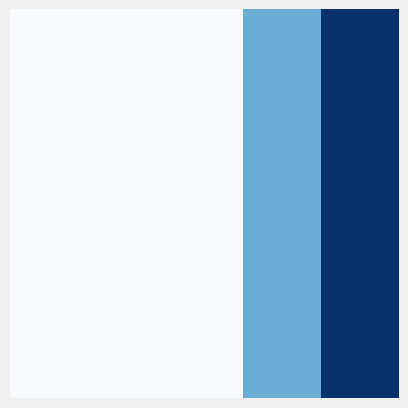

In [10]:
# define the image_b
image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

print(image_b)

# show only image_b
plt.imshow(image_b, cmap='Blues', vmin=0, vmax=255)
#plt.imshow(image_b, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

### b. 加权平均图片 --> 灰度图像，单通道图像

[[204.   107.52  10.2    7.68   5.1 ]
 [204.   107.52  10.2    7.68   5.1 ]
 [204.   107.52  10.2    7.68   5.1 ]
 [204.   107.52  10.2    7.68   5.1 ]
 [204.   107.52  10.2    7.68   5.1 ]]


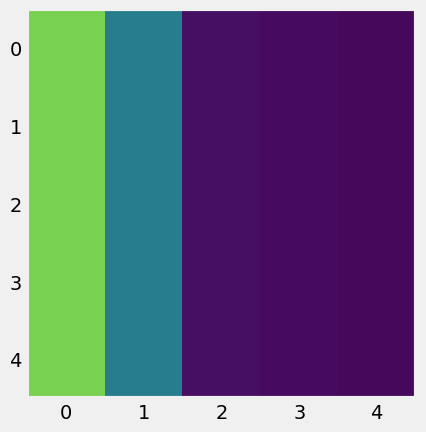

In [11]:
image_gray = .8*image_r + .04*image_g + .02*image_b

print(image_gray)

# show only image_gray
plt.imshow(image_gray, vmin=0, vmax=255)
#plt.imshow(image_gray, cmap='gray', vmin=0, vmax=255)
plt.axis('on')
plt.grid(False)
plt.show()

### c. 叠加单通道图像 --> 多通道图像
* 每一辐图像成为一个通道
* `彩色图像具有3个通道`，每种颜色一个通道：红色、绿色和蓝色，按序排列
* `np.stack([image1, image2, image...], axis=x)`

<class 'numpy.ndarray'>
(5, 5, 3)
[[[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]]


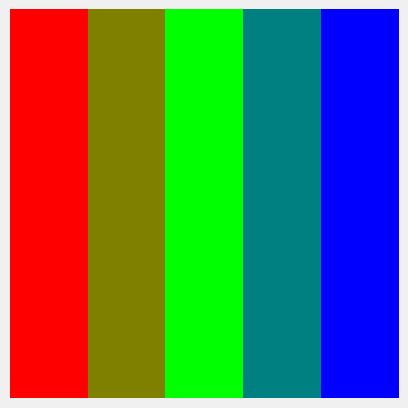

In [12]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

print(type(image_rgb))
print(image_rgb.shape)
print(image_rgb)

# show only image_rgb, axis = 0
#plt.imshow(np.transpose(image_rgb, (1, 2, 0)), vmin=0, vmax=255)

# show only image_rgb, axis = 1
#plt.imshow(np.transpose(image_rgb, (0, 2, 1)), vmin=0, vmax=255)

plt.imshow(image_rgb, vmin=0, vmax=255)
#plt.imshow(image_rgb, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

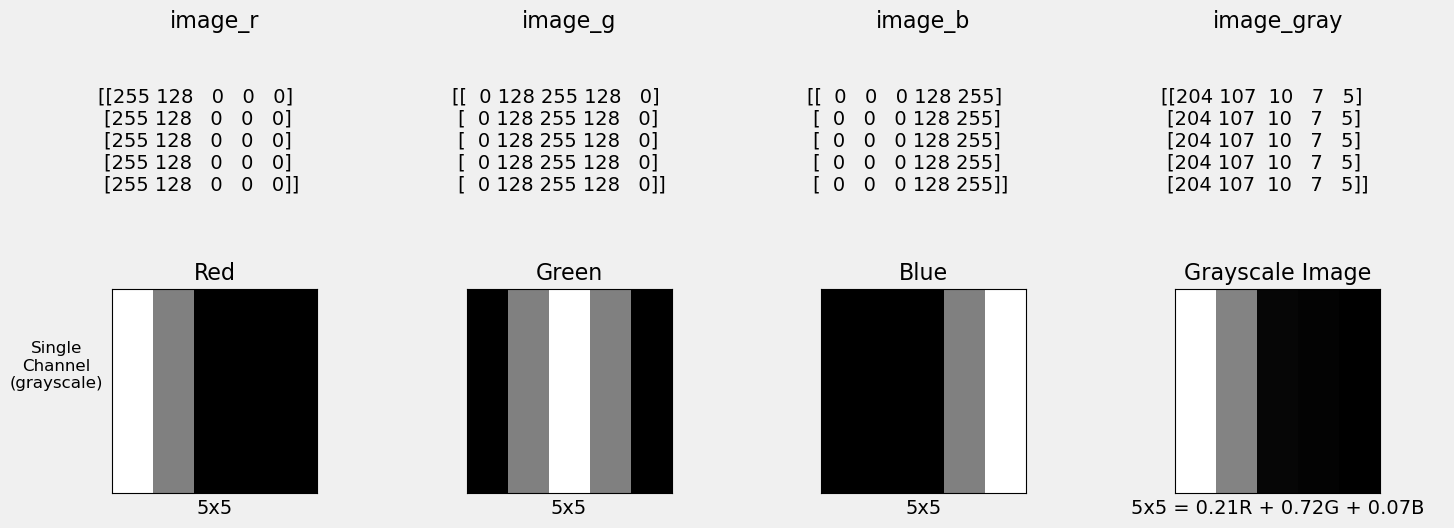

In [13]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))
fig

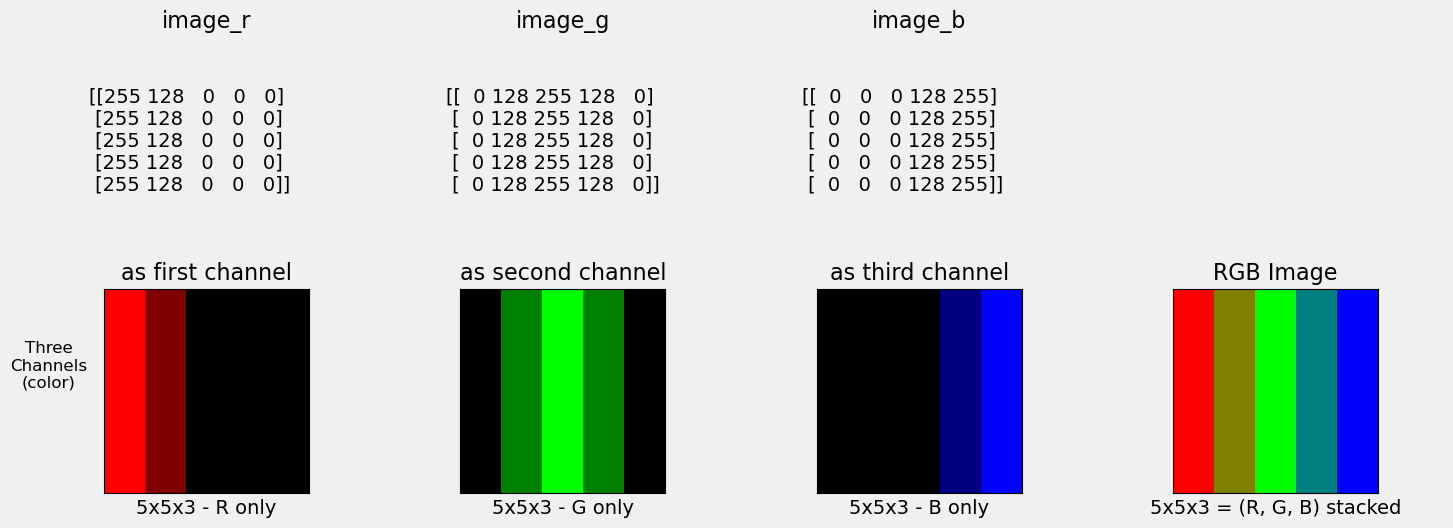

In [14]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))
fig

### NCHW vs NHWC

小批量`图像的形状`：
* N：图像数量
* C：每幅图像中的通道或滤波器的数量
* H：每幅图像的高度
* W：每幅图像的宽度

不同软件包或框架的格式不同：
* PyTorch 使用 NCHW
* TensorFlow 使用 NHWC
* PIL 使用 HWC

In [15]:
images.shape

(300, 1, 5, 5)

#### a. `np.squeeze()`

(1, 5, 5)
[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]


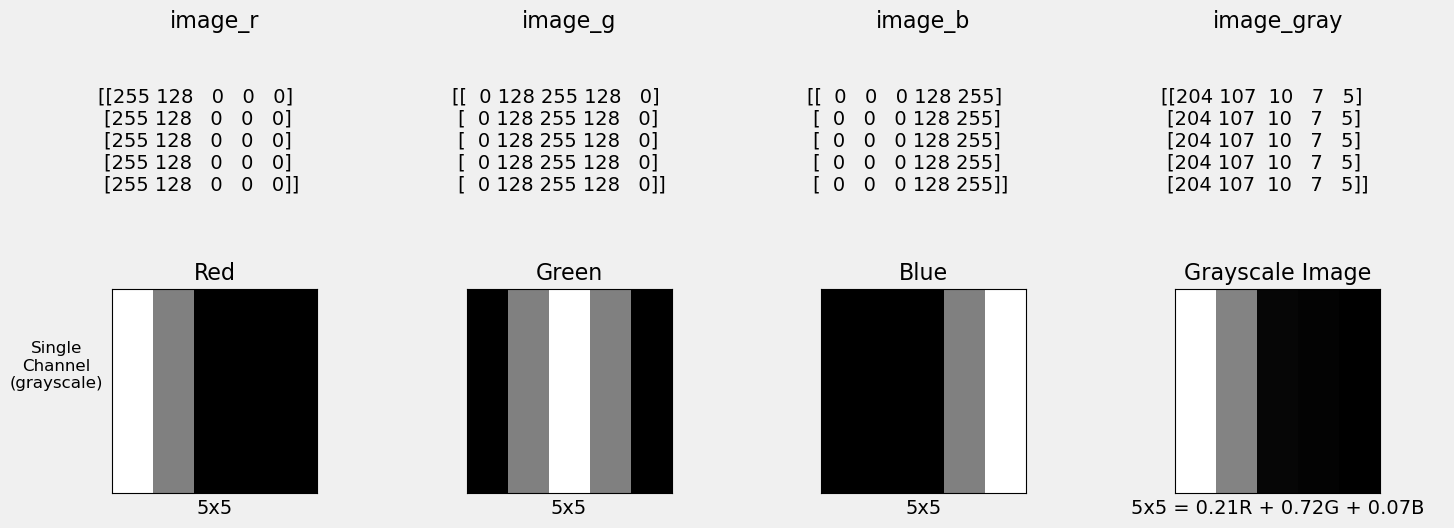

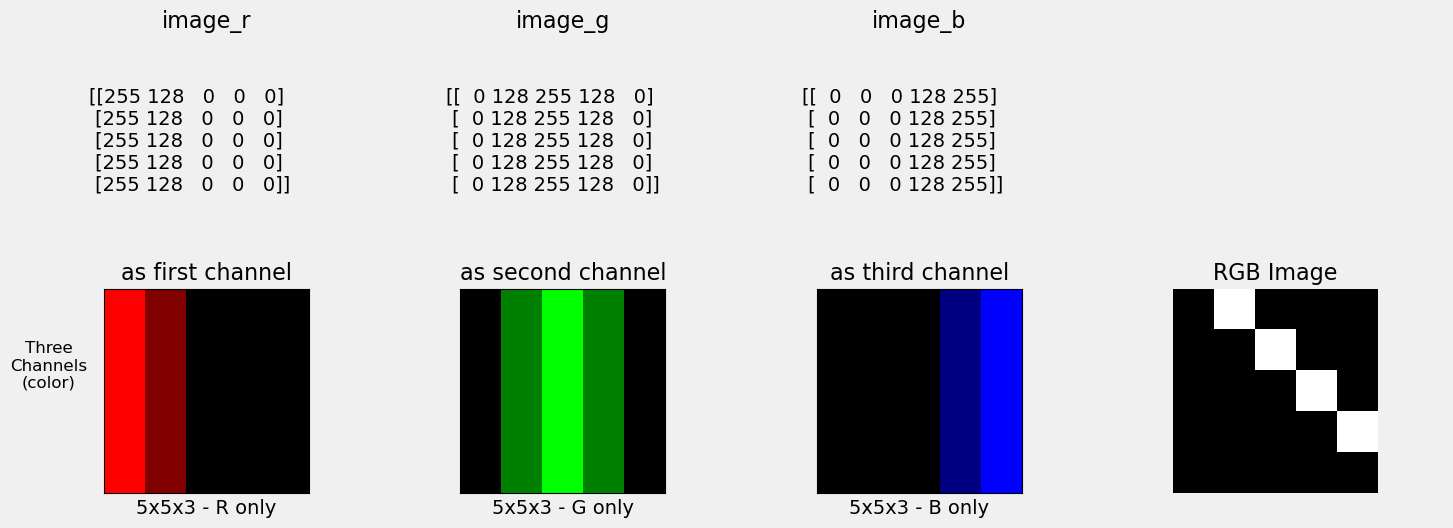

In [16]:
example = images[7]

print(example.shape)
print(example)

# show images[7]
plt.imshow(np.squeeze(images[7]), cmap='gray', vmin=0, vmax=255)
#plt.imshow(images[7]), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

**Note:**

The `np.squeeze()` function removes single-dimensional entries (axes with size 1) from the shape of an array.

For example:
- If `images[7]` has a shape of `(1, 5, 5)` (e.g., a single-channel image with an explicit channel dimension), `np.squeeze(images[7])` will remove the first dimension, resulting in a shape of `(5, 5)`.
- If there are no single-dimensional axes, the array remains unchanged.

In this context, `np.squeeze()` is used to remove the channel dimension (if it exists) so that the image can be displayed as a 2D grayscale image using `plt.imshow()`.

#### b. `np.tanspose()`

(5, 5, 1)


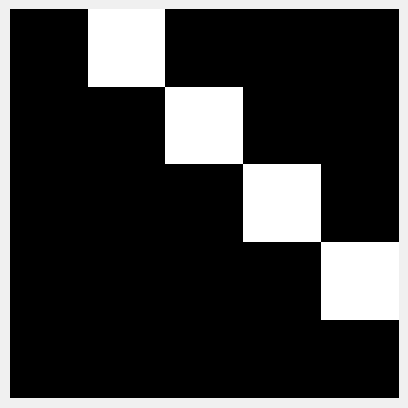

In [17]:
example_hwc = np.transpose(example, (1, 2, 0))
print(example_hwc.shape)

# show images[7] after transpose
#plt.imshow(np.squeeze(images[7]), cmap='gray', vmin=0, vmax=255)
plt.imshow(example_hwc, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

**Note:**

In the context of `np.transpose(example, (1, 2, 0))`, the tuple `(1, 2, 0)` specifies the new order of the axes for the array `example`.

- `0`, `1`, and `2` represent the original axes of the array.
- `(1, 2, 0)` means:
  - The original axis `1` becomes the first axis in the transposed array.
  - The original axis `2` becomes the second axis in the transposed array.
  - The original axis `0` becomes the third axis in the transposed array.

For example, if `example` has a shape `(C, H, W)` (e.g., channels-first format, common in PyTorch), after transposing, it will have a shape `(H, W, C)` (e.g., channels-last format, common in TensorFlow or PIL).

In [18]:
example_hwc

array([[[  0],
        [255],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [255],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [255],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [255]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0]]], dtype=uint8)

## Torchvision

`Torchvision` is a package containing popular datasets, model architectures, and
common image transformations for computer vision.

数据集：MINIST, ImageNet, CIFAR， ImageFolder

### Models

PyTorch also includes the most popular `model architectures`, including their pre-trained weights, for tackling many tasks like `image classification`, `semantic segmentation`, `object detection`, `instance segmentation`, `person keypoint detection`,and `video classification`.

Among the many models, we can find the well-known `AlexNet`, `VGG` (in its many
incarnations: VGG11, VGG13, VGG16, and VGG19), `ResNet` (also in many flavors:
ResNet18, ResNet34, ResNet50, ResNet101, ResNet152), and `Inception V3`.

### Transforms

#### a. `ToImage()`

In [19]:
image_tensor = ToImage()(example_hwc)

print(type(image_tensor))
image_tensor, image_tensor.shape

<class 'torchvision.tv_tensors._image.Image'>


(Image([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=torch.uint8, ),
 torch.Size([1, 5, 5]))

In [20]:
isinstance(image_tensor, torch.Tensor)

True

#### b. `ToDtype()`

In [21]:
example_tensor = ToDtype(torch.float32, scale=True)(image_tensor)
example_tensor

Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )

#### c. `ToTensor()` with `Compose()`
* ToTensor() - 可以将数值从[0, 255]范围缩放到[0.0, 1.0]范围

In [22]:
def ToTensor():
    return Compose([ToImage(), ToDtype(torch.float32, scale=True)])

tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)

print(type(example_tensor))
example_tensor, example_tensor.shape

<class 'torchvision.tv_tensors._image.Image'>


(Image([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]], ),
 torch.Size([1, 5, 5]))

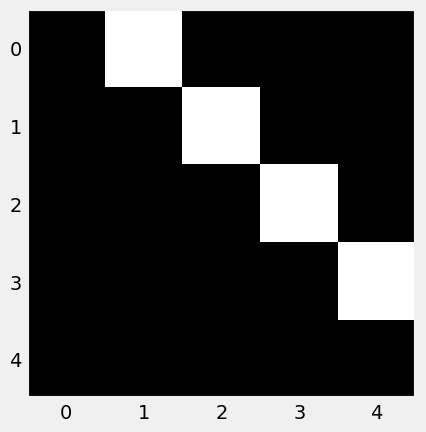

In [23]:
# example_tesnor is CHW, PIL is HWC

plt.imshow(np.transpose(example_tensor, (1, 2, 0)), cmap='gray')
plt.grid(False)
plt.axis('on')
plt.show()

#### d. `ToPILImage()`
* 它是一个真实的`PIL图像`，不再是一个Numpy数组，可以使用matplotlib来可视化
* 输入：可以是PyTorch形状（CHW）的`张量`，或者PIL形状（HWC）的`Numpy数组`

In [24]:
example_img = ToPILImage()(example_tensor)
print(type(example_tensor))
print(example_tensor.shape)
print(type(example_img))

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([1, 5, 5])
<class 'PIL.Image.Image'>


In [25]:
# tensor with CHW style, transpose change the shape, but still is CHW shape
example_tensor_hwc = np.transpose(example_tensor, (1, 2, 0))
print(type(example_tensor_hwc))
print(example_tensor_hwc.shape)

#example_img = ToPILImage()(example_tensor_hwc)
#print(type(example_img))

<class 'torch.Tensor'>
torch.Size([5, 5, 1])


In [26]:
example_np = np.array(example_img)
print(type(example_np))
print(example_np.shape)

example_img = ToPILImage()(example_np)
print(type(example_img))

<class 'numpy.ndarray'>
(5, 5)
<class 'PIL.Image.Image'>


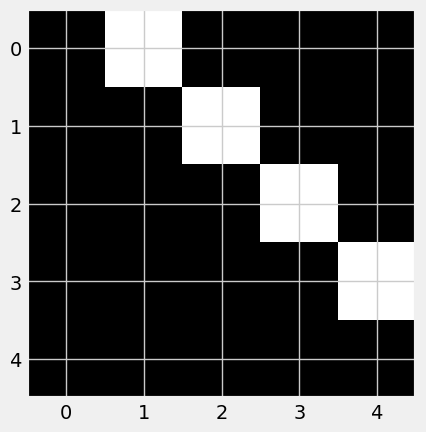

In [27]:
plt.imshow(example_img, cmap='gray')
plt.grid(True)
plt.axis('on')
plt.show()

### Transforms on Images

#### a. `数据增强`：

不收集更多数据的情况下扩展数据集（增强数据集）的技术
* 典型操作：Resize, CenterCrop, GrayScale, RandomHorizontalFlip, RandomRotation
* 有趣的转换：旋转、移动、翻转、裁剪、模糊、放大、添加噪音、擦除部分...

In [28]:
flipper = RandomHorizontalFlip(p=0.5)
flipped_img = flipper(example_img)
print(type(flipped_img))
print(flipped_img.size)

<class 'PIL.Image.Image'>
(5, 5)


**Note:**

The `p` value in `RandomHorizontalFlip(p=1.0)` specifies the probability of flipping the image horizontally.

- `p=1.0`: The image will always be flipped horizontally.
- `p=0.0`: The image will never be flipped.
- `p=0.5`: The image has a 50% chance of being flipped.

You can adjust the `p` value to control the likelihood of the transformation being applied. For example:



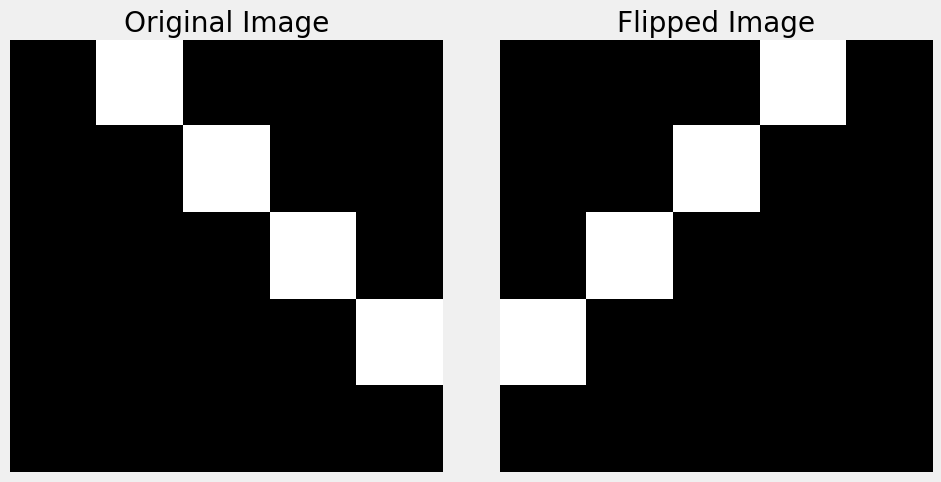

In [29]:
# example_img vs flipped_img
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# example_img
axes[0].imshow(example_img, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# flipped_img
axes[1].imshow(flipped_img, cmap='gray')
axes[1].set_title("Flipped Image")
axes[1].axis('off')

# show the plot
plt.tight_layout()
plt.show()

### Tensor-only Transforms

* 只有4种转换可将（非图像）张量作为输入：LinearTransformation、Normalize、RandomErasing和ConvertImageDtype

In [30]:
img_tensor = tensorizer(flipped_img)

print(flipped_img)
print(img_tensor)

<PIL.Image.Image image mode=L size=5x5 at 0x19E325BE8D0>
Image([[[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], )


#### `Normalize` Transform - 归一化转换

$$
\Large
\begin{aligned}
\text{input} = 0 \implies \frac{0 - \text{mean}}{\text{std}}= \frac{0 - 0.5}{0.5}&=-1
\\
\text{input} = 1 \implies \frac{1 - \text{mean}}{\text{std}}= \frac{1 - 0.5}{0.5}&=1
\end{aligned}
$$

In [31]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

Image([[[-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]]], )

* 归一化转换会修改给定特征或特征集的取值范围，在训练神经网络时，最好使用具有对称的取值范围
* 设置`均值=0.5`，`标准差=0.5`，执行`最小-最大缩放`（如Scikit-Learn的 MinMaxScaler)
* 转换需要两个元组作为参数：一个元组作为均值，一个作为标准差，每个元组的值与图像中的通道一样多

### Composing Transforms - 组合转换

* Compose的作用：将多个转换组合成一个单一的，大的转换
* 确保给定转换的输出是下一个转换的适当输入

In [32]:
composer = Compose([RandomHorizontalFlip(p=1.0),
                    Normalize(mean=(.5,), std=(.5,))])

In [33]:
composed_tensor = composer(example_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [34]:
composed_tensor

Image([[[-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]]], )

In [35]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )


In [36]:
example_tensor = torch.as_tensor(example / 255).float()
print(example_tensor)
print(example_tensor.shape)

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])
torch.Size([1, 5, 5])


## Data Preparation / 20250507

In [37]:
# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

In [38]:
x_tensor.shape, y_tensor.shape

(torch.Size([300, 1, 5, 5]), torch.Size([300, 1]))

### Understanding `labels.reshape(-1, 1)`

The `labels.reshape(-1, 1)` expression is reshaping the `labels` array into a 2D array (matrix) with a specific format. Let me explain what this does:

1. **Starting Point**: The `labels` array in your notebook is a 1D array (vector) of shape `(300,)` containing binary values (0 or 1) that represent the class labels for your images.

2. **The `-1` Parameter**: 
   - In NumPy's `reshape()` function, using `-1` as a dimension tells NumPy to automatically calculate the size of that dimension based on the total number of elements.
   - It essentially means "figure out this dimension for me" while maintaining the total number of elements.

3. **The Result**: 
   - `labels.reshape(-1, 1)` transforms the 1D array of shape `(300,)` into a 2D array of shape `(300, 1)`.
   - Each label value is now in its own row in a single column matrix.

### Why Reshape in This Way?

This reshaping is done for several important reasons:

1. **Model Requirements**: PyTorch models typically expect targets in a specific format. For binary classification tasks, the target should be a 2D tensor with shape `(batch_size, 1)`.

2. **Broadcasting Compatibility**: Having targets as a column vector `(n, 1)` rather than a row vector `(1, n)` or a flat array `(n,)` ensures proper broadcasting during operations like loss calculation.

3. **Tensor Operations**: Many tensor operations in deep learning frameworks work better with 2D tensors rather than 1D tensors.

### Example

If you have:


In [39]:
labels = np.array([0, 1, 1, 0, 1])  # Shape (5,)



After applying `labels.reshape(-1, 1)`, you get:


In [40]:
reshaped_labels = np.array([[0], [1], [1], [0], [1]])  # Shape (5, 1)



This 2D representation makes the array ready to be converted to a PyTorch tensor for use in training your models.

### Dataset Transforms

In [41]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [42]:
composer = Compose([RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y_tensor, transform=composer)

### SubsetRandomSampler

打乱数据，后台使用`RandomSampler`实现：
* `训练集`创建数据加载器是，设置参数shuffle=True，需要小批量时，`采样器`随机抽取一些索引，并返回这些索引对应的数据点

不打乱数据，后台使用`SequentialSampler`实现：
* `验证集`的数据加载器中，需要小批量时，`采样器`会按照顺序简单的返回一系列索引，及其对应的数据点

`采样器`可以返回要用于数据加载的`索引序列`。采样器将`Dataset`作为参数，但并不是所有的采样器都是这样。

`SubsetRandomSampler`从列表中抽取索引，作为`参数`给出，不用替换。与采样器一样，这些索引用于从数据集中加载数据。如果索引不在列表中，则永远不会使用相应的数据点。

### Helper Function #4

In [ ]:
index_splittedef r(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [459]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

`random_split`需要一个列表，其中包含每个拆分中数据点的确切数量，

`index_splitter`调用`random_split`来拆分包含索引列表的张量，生成的拆分对象时`Subset`

#### `Subset.indices`属性:

In [460]:
train_idx.indices

[118,
 170,
 148,
 239,
 226,
 146,
 168,
 195,
 6,
 180,
 157,
 2,
 160,
 66,
 46,
 276,
 126,
 212,
 119,
 77,
 53,
 237,
 252,
 202,
 200,
 289,
 135,
 186,
 231,
 211,
 35,
 293,
 229,
 265,
 256,
 134,
 191,
 214,
 8,
 83,
 150,
 190,
 208,
 209,
 275,
 60,
 295,
 142,
 251,
 176,
 260,
 3,
 31,
 0,
 137,
 20,
 81,
 287,
 181,
 129,
 166,
 97,
 110,
 206,
 267,
 241,
 109,
 177,
 27,
 52,
 43,
 245,
 247,
 141,
 68,
 131,
 217,
 78,
 185,
 49,
 96,
 14,
 111,
 234,
 284,
 263,
 269,
 101,
 32,
 285,
 79,
 297,
 94,
 85,
 11,
 5,
 80,
 165,
 183,
 4,
 33,
 100,
 73,
 235,
 277,
 16,
 144,
 132,
 167,
 130,
 45,
 48,
 201,
 99,
 34,
 138,
 178,
 244,
 225,
 173,
 95,
 22,
 197,
 174,
 90,
 223,
 274,
 92,
 279,
 19,
 74,
 28,
 162,
 133,
 151,
 37,
 299,
 18,
 203,
 13,
 156,
 268,
 259,
 116,
 70,
 71,
 230,
 108,
 238,
 47,
 163,
 30,
 188,
 64,
 216,
 121,
 187,
 72,
 221,
 258,
 44,
 179,
 272,
 159,
 253,
 280,
 140,
 120,
 62,
 271,
 57,
 1,
 149,
 9,
 29,
 194,
 158,
 115,
 1

In [461]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [462]:
# Builds a loader of each set
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sampler)

In [463]:
# Check the number of batches - 小批量的数量
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

可以使用单个`数据集`来加载数据，因为`拆分`由`采样器`控制。但是仍然需要`两个数据加载器`，每个都使用对应的采样器。
* 数据集：dataset
* 数据加载器：DataLoader
* 采样器：sampler=train_sampler / val_sampler

如果`使用采样器`，则不能设置 `shuffle=True --> False`

### Data Augmentation Transformations - 数据增强转换

`数据增强`：
* 一般只将`数据增强`应用于`训练数据`
* 数据增强是使用`组合转换`完成的，它应用于数据集中的`所有点`

`合成器 Compose`：
* train_composer 对数据进行增强，然后对其进行缩放(最小-最大)
* val_composer 仅缩放数据(最小-最大)

In [464]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [465]:
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])

val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

In [466]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

**Note:**
* `不使用采样器`执行拆分，可以设置参数 `shuffle=True`
* 如果`不执行数据增强`，可能继续`使用采样器和单个数据集`

### WeightedRandomSampler
* A weighted sampler - 加强采样器

#### `tensor.unique()`
* return_counts=True: 获取现有标签的列表和对应的数据点数量

In [467]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts)

tensor([0., 1.]) tensor([ 80, 160])


In [468]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

#### 权重：
* 使用计数的倒数计算权重 - 少数类应该有更大的权重
* 使用权重对少数类进行过度表示，以补偿数据的不平衡性

In [469]:
weight_neg = 1 / 80
weight_pos = 1 / 160

weight_neg, weight_pos

(0.0125, 0.00625)

In [470]:
sample_weights = weights[y_train_tensor.squeeze().long()]

print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


#### `tensor.squeeze()` 方法

`tensor.squeeze()` 是 PyTorch 中一个用于移除张量中维度为 1 的轴（单维度）的方法。让我为你解释这个方法的工作原理：



##### 基本功能
`squeeze()` 方法会移除张量中所有维度为 1 的轴，从而使张量的形状更加紧凑。

##### 参数选项
- 不带参数调用：`tensor.squeeze()` - 移除所有维度为 1 的轴
- 带参数调用：`tensor.squeeze(dim)` - 只移除指定维度上的单维轴

##### 从您的代码中看
在您的代码中，您使用了这个方法移除标签张量中的冗余维度：



In [471]:
y_train_tensor.squeeze().shape  # 从 (240, 1) 变为 (240,)

torch.Size([240])

##### 实际例子

让我展示几个例子来说明这个方法的作用：

In [ ]:
# 例子 1: 移除所有单维轴
x = torch.tensor([[[1], [2], [3]]])  # 形状是 (1, 3, 1)
print(x.shape)
y = x.squeeze()  # 形状变为 (3,)
print(y.shape)

# 例子 2: 只移除特定维度
x = torch.tensor([[[1], [2], [3]], [[4], [5], [6]]])  # 形状是 (2, 3, 1)
print(x.shape)

y = x.squeeze(0)  # 只移除第0维，形状变为 (3, 1)
print(y.shape)    # 移除第0维，无法完成，形状变为 (2，3, 1)

z = x.squeeze(2)  # 只移除第2维，形状变为 (2, 3)
print(z.shape)    # 只移除第2维，形状变为 (2, 3)

torch.Size([1, 3, 1])
torch.Size([3])
torch.Size([2, 3, 1])
torch.Size([2, 3, 1])
torch.Size([2, 3])


##### 应用场景
在您的代码中，`squeeze()` 被用于：

1. 数据预处理中调整张量形状
2. 准备标签数据以便与模型输出匹配
3. 在计算 `sample_weights` 时需要扁平化张量

这行代码通过移除标签张量的单维轴，使其可以作为索引使用。

`squeeze()` 是处理张量形状的一个非常实用的方法，特别是在数据预处理和模型训练过程中。

#### `tensor.long()`方法

`tensor.long()` 方法用于将张量转换为Long (整数) 数据类型。这在您需要使用张量值作为索引或处理需要整数数据类型的操作时非常有用。

在您的notebook中，这个方法在访问基于类标签的权重时被使用：

In [473]:
sample_weights = weights[y_train_tensor.squeeze().long()]



这行代码的分解说明：

1. 原始的 `y_train_tensor` 形状为 (240, 1)，包含浮点值 (0.0 或 1.0)
2. 经过 `squeeze()` 操作后，形状变为 (240,)
3. `long()` 方法将这些浮点值转换为64位整数 (0 或 1)
4. 这些整数值随后被用作索引，从 `weights` 张量中选择对应的值

这种转换是必要的，因为：

1. PyTorch要求索引必须是整数张量，而不是浮点类型
2. 当使用张量进行索引操作时，索引必须具有Long/Int数据类型

如果您尝试直接使用浮点值对张量进行索引，PyTorch会抛出错误：
"indices must be either a torch.LongTensor or a torch.ByteTensor"

这个功能可以通过一个简单的例子来展示：



In [474]:
weights = torch.tensor([0.0125, 0.0063])  # 类0和类1的权重
labels = torch.tensor([0.0, 1.0, 0.0])    # 一些作为浮点数的类标签

# 这会失败：
# weights[labels]  

# 这正确工作：
weights[labels.long()]  # tensor([0.0125, 0.0063, 0.0125])

tensor([0.0125, 0.0063, 0.0125])



`long()` 方法是PyTorch中多种类型转换方法之一，类似于 `float()`、`int()`、`bool()` 等。

In [475]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [476]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

#### WeightedRandomSampler的主要参数：
* weights: 一个权重序列
* num_samples: 从数据集中抽取的样本数，典型值是权重序列的长度
* replacement: 默认值 True，使用替换采样，仅当 num_samples < 数据集长度 时，设置 False 才有意义
* generator: 可选，伪随机数生成器 - 种子

### Helper Function #5

In [477]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [478]:
# 参数：包含标签的张量
sampler = make_balanced_sampler(y_train_tensor)

### Seeds and more (seeds)

#### `x_loader.sampler.generator.manual_seed()`

In [479]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

In [480]:
train_loader.sampler.generator.manual_seed(42)
random.seed(42)

In [481]:
# t[1] 是标签
torch.tensor([t[1].sum() for t in iter(train_loader)]).sum()

tensor(123.)

In [482]:
torch.tensor([t[1].numel() for t in iter(train_loader)])

tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [483]:
torch.tensor([t[0].numel() for t in iter(train_loader)])

tensor([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400,
        400])

#### **解释**：数据为什么是`400个值`：

让我查看一下批量数据的形状来理解为什么每个批量中`t[0]`可能有400个值。让我查看一下为什么每个批量中的`t[0]`会有400个值。

在查看代码后，我发现这与数据的形状和批量大小有关。在Chapter04.ipynb中，我们可以看到:

1. 图像数据由5x5像素的单通道图像组成，它们在加载到PyTorch张量时的形状是[batch_size, 1, 5, 5]。

2. 在查看一个批量的形状时，代码显示:


In [484]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape  # 输出: torch.Size([16, 1, 5, 5])

torch.Size([16, 1, 5, 5])



这表明每个批量包含16个图像，每个图像是1个通道，5x5像素。

3. 当计算总元素数时，对于每个批量:
   - 每个图像: 1(通道) × 5(高) × 5(宽) = 25个像素值
   - 每个批量: 16(图像) × 25(每个图像的像素值) = 400个值

所以当你用`t[0]`访问批量中的输入数据时，它包含了400个值，这是16个图像的所有像素值的总和。批量中的每个图像有25个像素值(5×5)，16个图像就有400个像素值。

这就是为什么当你计算`t[0].numel()`(计算张量中的元素总数)时，结果是400。

此外，数据加载器使用`batch_size=16`创建，这就是为什么每个批量包含16个样本的原因，从而导致总共有400个像素值。

In [485]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    try:
        self.train_loader.sampler.generator.manual_seed(seed)
    except AttributeError:
        pass
    
setattr(StepByStep, 'set_seed', set_seed)

#### 多个种子：
* torch.manual_seed(42)
* np.random.seed(42)
* Torchvision 0.8之前的版本，一些代码依赖Python的本机随机模块，而不是PyTorch的随机生成器

### Putting It Together

In [ ]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
#y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Pixels as Features

In [487]:
dummy_xs, dummy_ys = next(iter(train_loader))
dummy_xs.shape

torch.Size([16, 1, 5, 5])

#### `nn.Flatten()` - 展平层将像素展平
* 每个像素和通道视为一个单独的特征

In [488]:
flattener = nn.Flatten()
dummy_xs_flat = flattener(dummy_xs)

print(dummy_xs_flat.shape)
print(dummy_xs_flat[0])
print(dummy_xs_flat[1])
print(dummy_xs_flat[2].shape)

torch.Size([16, 25])
tensor([ 1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.])
torch.Size([25])


#### `tensor.reshape()` - 改变形状

In [165]:
dummy_xs_reshape = dummy_xs_flat.reshape(-1, 5, 5)
print(dummy_xs_reshape[0].shape)

torch.Size([5, 5])


## Shallow Model - 浅层模型 / 20250515

$$
\Large \text{P}(y=1) = \sigma(z) = \sigma(w_0x_0+w_1x_1+\cdots+w_{24}x_{24})
$$

![](images/classification.png)

### Notation - 符号：权重W 和 特征X 的向量表示

$$
\Large W =
\underset{(25 \times 1)}{
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_{24}
\end{bmatrix}};
X = 
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T \cdot X 
=\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}} 
=
\underset{(1 \times 25)}{
\begin{bmatrix}
w_0 & w_1 & \cdots & w_{24}
\end{bmatrix}}
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
& = w_0x_0 + w_1x_1 + \cdots + w_{24}x_{24}
\end{aligned}
$$

### Model Configuration

In [166]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [167]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

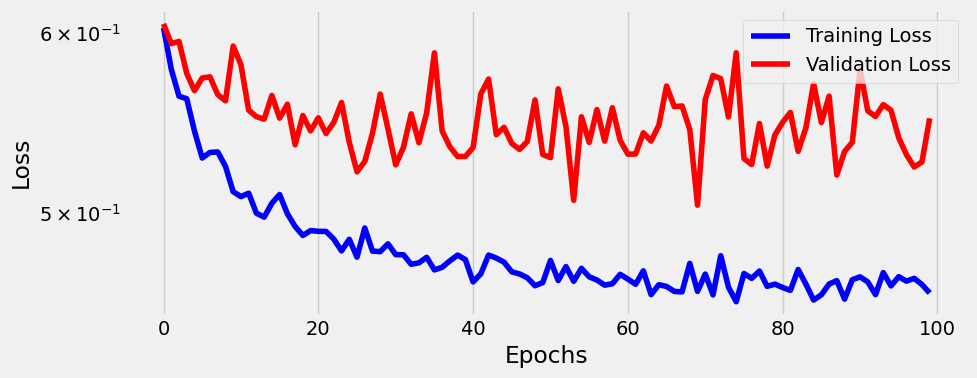

In [170]:
fig = sbs_logistic.plot_losses()
fig

## Deep-ish Model - 深层模型

![](images/classification_equiv.png)

### Model Configuration

In [171]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [172]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

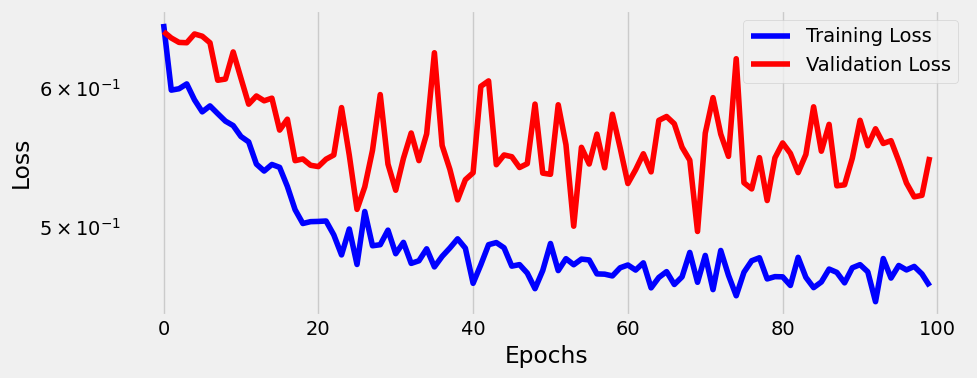

In [173]:
fig = sbs_nn.plot_losses()
fig

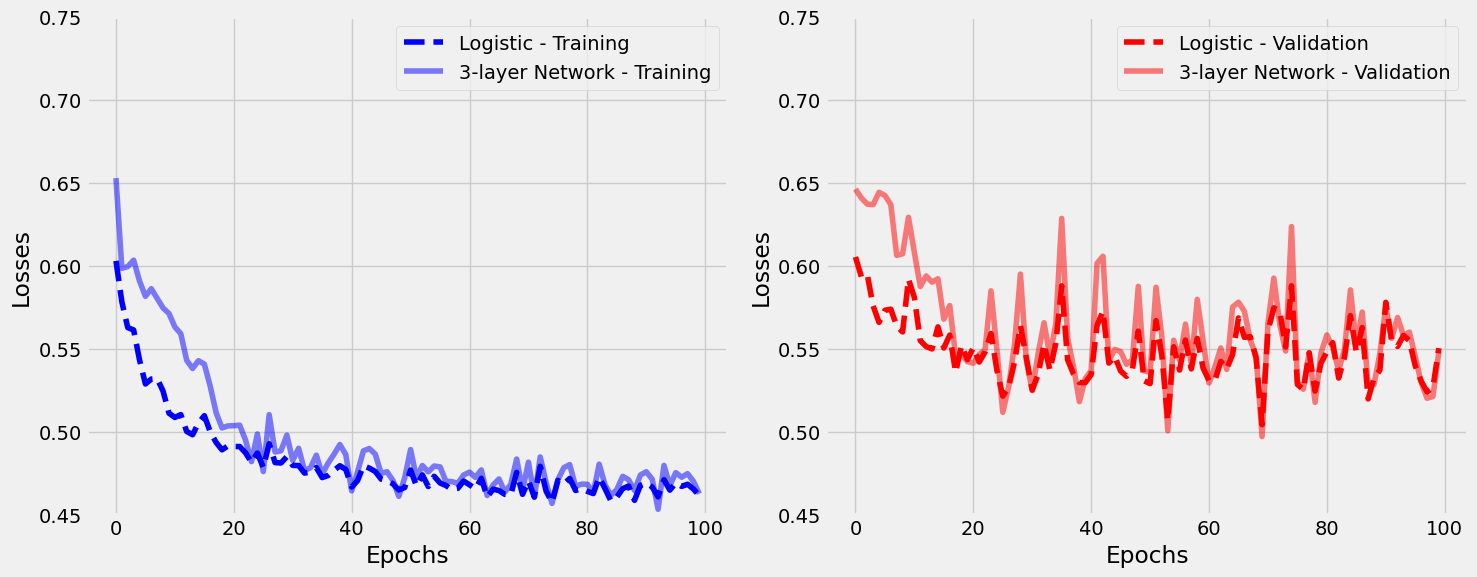

In [175]:
fig = figure5(sbs_logistic, sbs_nn)
fig

### Show Me the Math!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden}\ \#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden}\ \#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
\\
\hline
\text{substituting } z's... &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
& &
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
& &
& &
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{multiplying...} & &
=
&
\underbrace{
\underset{(1 \times 25)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}}_{\text{Matrices Multiplied}}
&
& & & & & & & &
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\end{array}
$$

![04_equivalence_deep_shallow_models_1.png](fig/04_equivalence_deep_shallow_models_1.png)

### Show Me the Code!

In [234]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [206]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [207]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [235]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

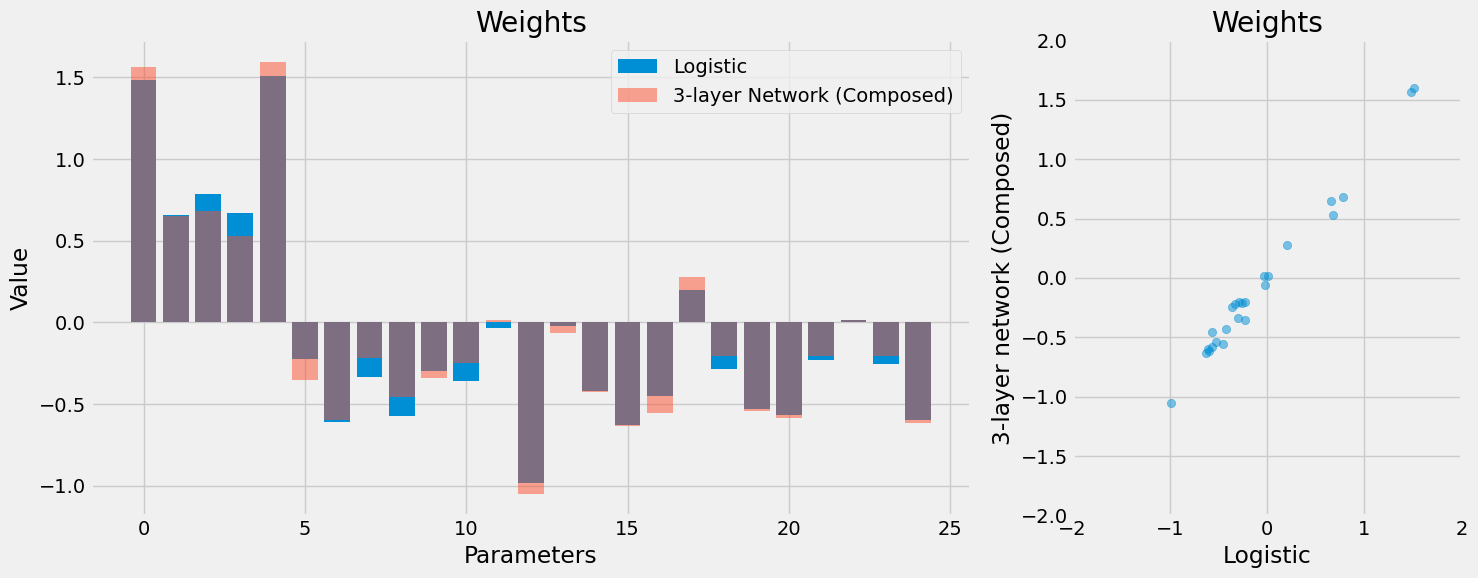

In [236]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)
fig

#### `.numel()` - 计算参数数量

In [237]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [238]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

### Weights as Pixels

In [212]:
w_nn_hidden0.shape

torch.Size([5, 25])

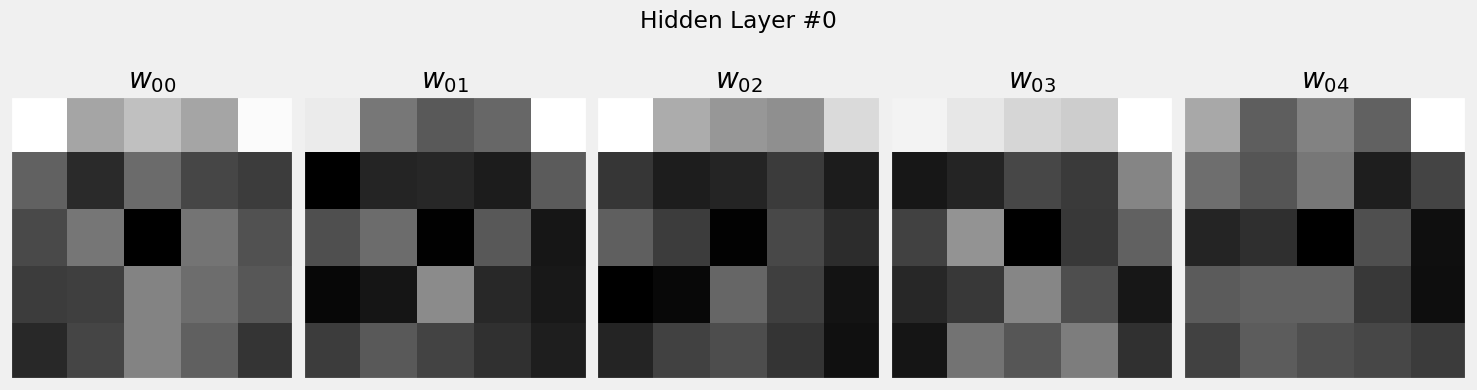

In [239]:
fig = figure7(w_nn_hidden0)
fig

`滤波器`：
* 在使用卷积神经网络(CNN)时，将权重可视化为图像是很常见的，这些图像称为滤波器
* 在CNN的模型中，真实的滤波器仅覆盖图像的某一部分

## Activation Functions - 激活函数

激活函数是`非线性函数`，它们要么`压扁`直线，要么`弯曲`直线，从而`打破`深层模型和浅层模型之间的`等价性`

### Sigmoid

$$
\Large \sigma(z) = \frac{1}{1 + e^{-z}}
$$

* `sigmoid` 输入 `logit` 值，输出 `概率`
* `Sigmoid` 激活函数将输入值 z `压扁` 到 (0, 1) 范围内
* Sigmoid 的`梯度峰值为0.25`，输入z值 的绝对值达到 5 时，它的值接近 0
* 任何给定层的激活值都是下一层的输入，Sigmoid的激活值`以0.5为中心`

d:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter4.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


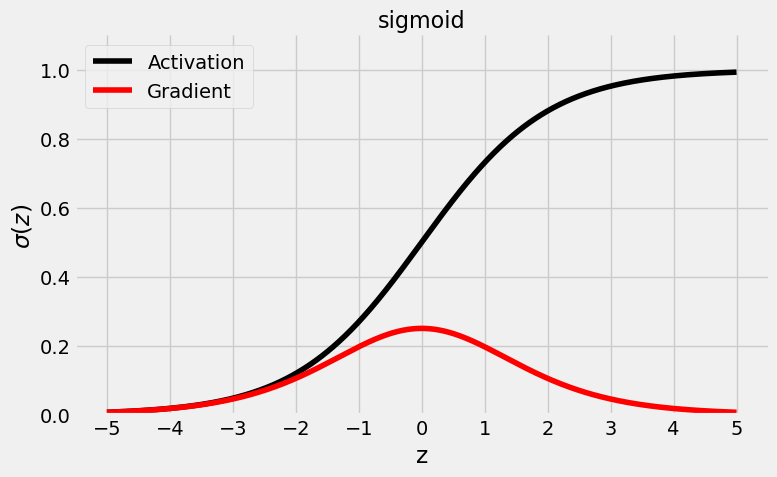

In [240]:
fig = plot_activation(torch.sigmoid)
fig

* `torch.sigmoid()` - 一个简单的函数
* `nn.Sigmoid()` - 从nn.Module继承的成熟类

In [215]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

In [216]:
nn.Sigmoid()(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

### Hyperbolic Tangent (Tanh) - 双曲正切

$$
\Large \sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

* `Tanh` 激活函数是 `Sigmoid` 的演变，它输出具有`零均值`的值
* `Tanh` 激活函数将输入值 z `压扁` 到 (-1, 1) 范围内
* Tanh 的激活值 `以 0 为中心`
* Tanh 的`梯度峰值为 1.0`，但是它下降速度更快。这是`梯度消失`问题的根本原因，它导致网络的训练逐渐变慢

d:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter4.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


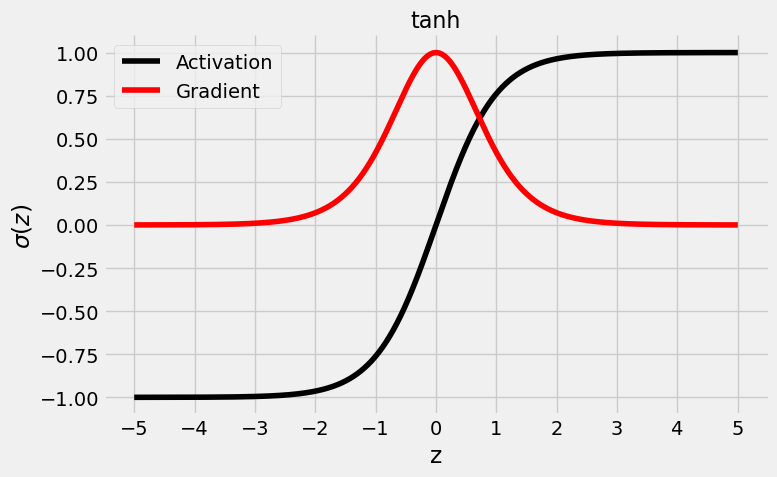

In [241]:
fig = plot_activation(torch.tanh)
fig

* `torch.tanh()` - 一个简单的函数
* `nn.Tanh()` - 从nn.Module继承的类

In [242]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

In [243]:
nn.Tanh()(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

### Rectified Linear Unit (ReLU) - 整流线性单元

$$
\Large
\begin{aligned}
\sigma(z) &=
\begin{cases}
z,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
\\
& \text{or}
\\
\sigma(z) &= \text{max}(0, z)
\end{aligned}
$$

* `压扁` 不是唯一的办法，使用`弯曲`线的激活函数解决线性等价问题
* `ReLU` 或其近亲是当今激活函数的常用选择，它解决了两个前辈的`梯度消失`问题，同时也是`计算梯度最快`的函数
* `ReLU` 不将值压扁到一个范围，它只保留`正值`，并将所有`负值变为0`
* 使用`ReLU`的好处是，它的梯度要么是`1`，要么是`0`，不再有梯度消失问题，这种模式导致`网络更快的收敛`
* 这种行为也可能导致所谓的`坏死神经元`，即输入始终为负的神经元，`激活值始终为零`
* 更糟糕的是，`负输入的梯度也为零`，这意味着权重没有更新，`神经元被卡住`了一样

`内部协变量偏移`问题：不同层中，激活值的不同分布
* 一般希望所有层都产生`相似分布的激活值`，理想情况以`0为中心且具有单位标准差`
* 解决此问题，使用`归一化层`，如 `BatchNorm`

d:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter4.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


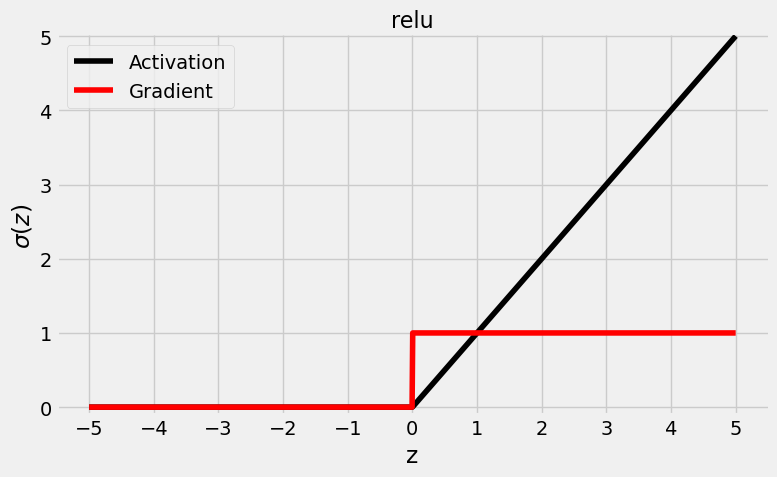

In [244]:
fig = plot_activation(torch.relu)
fig

PyTorch 中实现 ReLU 的 3 种方式：
* `F.relu`, `nn.ReLU()`, `clamp` 
* `F`： functional, 它是 torch.nn.functional 的缩写

In [221]:
dummy_z = torch.tensor([-3., 0., 3.])
F.relu(dummy_z)

tensor([0., 0., 3.])

In [222]:
nn.ReLU()(dummy_z)

tensor([0., 0., 3.])

In [223]:
dummy_z.clamp(min=0)

tensor([0., 0., 3.])

### Leaky ReLU - 泄露ReLU

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
0.01z,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+0.01\ \text{min}(0,z)
\end{aligned}
$$

* `泄露ReLU`：对于负输入，它返回一个很小的`激活值`，并产生一个很小的梯度，而不是两者都是固定值0
* 对于负值，乘数0.01称为`泄露系数`

d:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter4.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


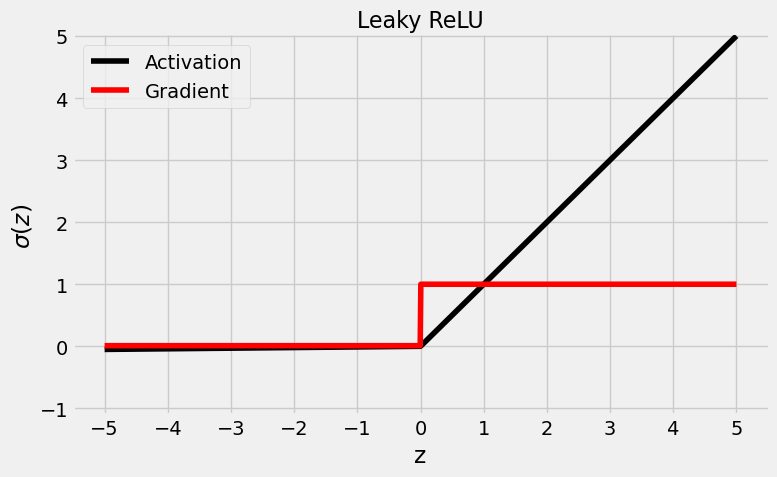

In [245]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')
fig

PyTorch 中实现 泄露 ReLU 有 2 种方式：
* `F.leaky_relu` 函数
* `nn.LeakyReLU()` 模块

In [225]:
dummy_z = torch.tensor([-3., 0., 3.])
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0300,  0.0000,  3.0000])

In [226]:
nn.LeakyReLU(negative_slope=0.02)(dummy_z)

tensor([-0.0600,  0.0000,  3.0000])

### Parametric ReLU (PReLU) - 参数ReLU

$$
\Large
\begin{aligned}
\sigma(z) =&
\begin{cases}
z,\ \text{if } z \ge 0
\\
az,\ \text{if } z < 0
\end{cases}
\\
\text{or}&
\\
\sigma(z)=&\text{max}(0,z)+a\ \text{min}(0,z)
\end{aligned}
$$

d:\04_Beginner\02_GitHub\fypbjchina\e02_PyTorchStepByStep\plots\chapter4.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


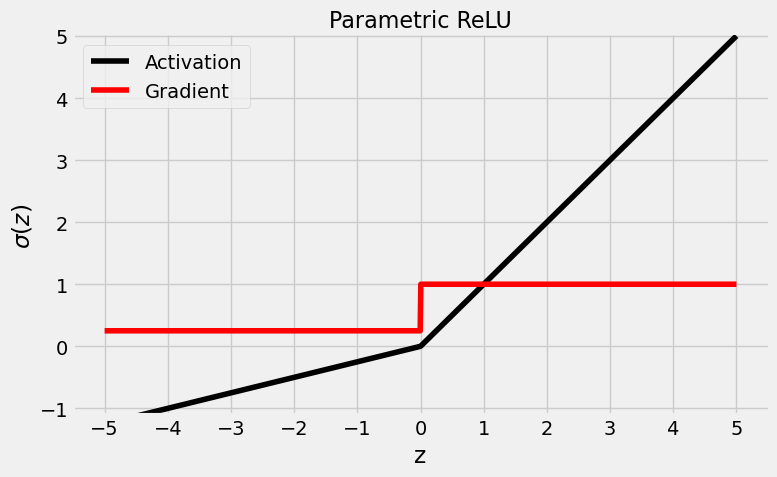

In [246]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')
fig

PyTorch 中实现 参数 ReLU 有 2 种方式：
* `F.prelu` 函数：参数weight设置参数a,`默认值是0.25`
* `nn.PReLU()` 模块: 设置参数没有意义，因为它会被学习，可以`设置初始值`

In [228]:
dummy_z = torch.tensor([-3., 0., 3.])
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.7500,  0.0000,  3.0000])

In [229]:
nn.PReLU(init=0.25)(dummy_z)

tensor([-0.7500,  0.0000,  3.0000], grad_fn=<PreluKernelBackward0>)

## Deep Model - 深度模型 + 激活函数

![](images/classification_relu2.png)

### Model Configuration

In [247]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

### Model Training

In [248]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

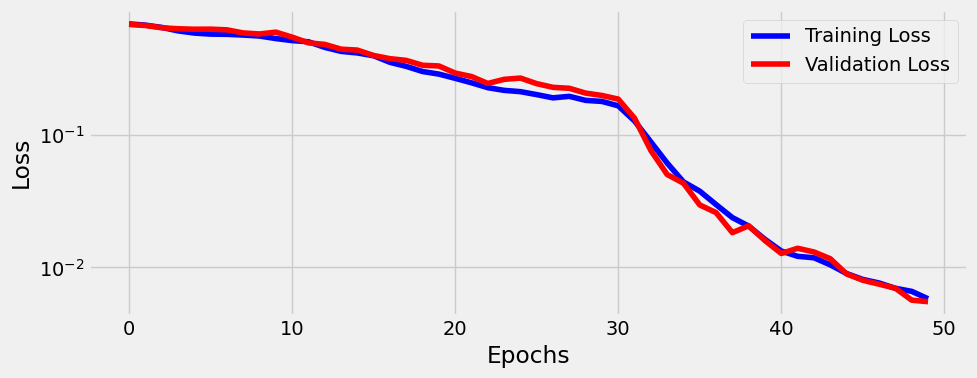

In [250]:
fig = sbs_relu.plot_losses()
fig

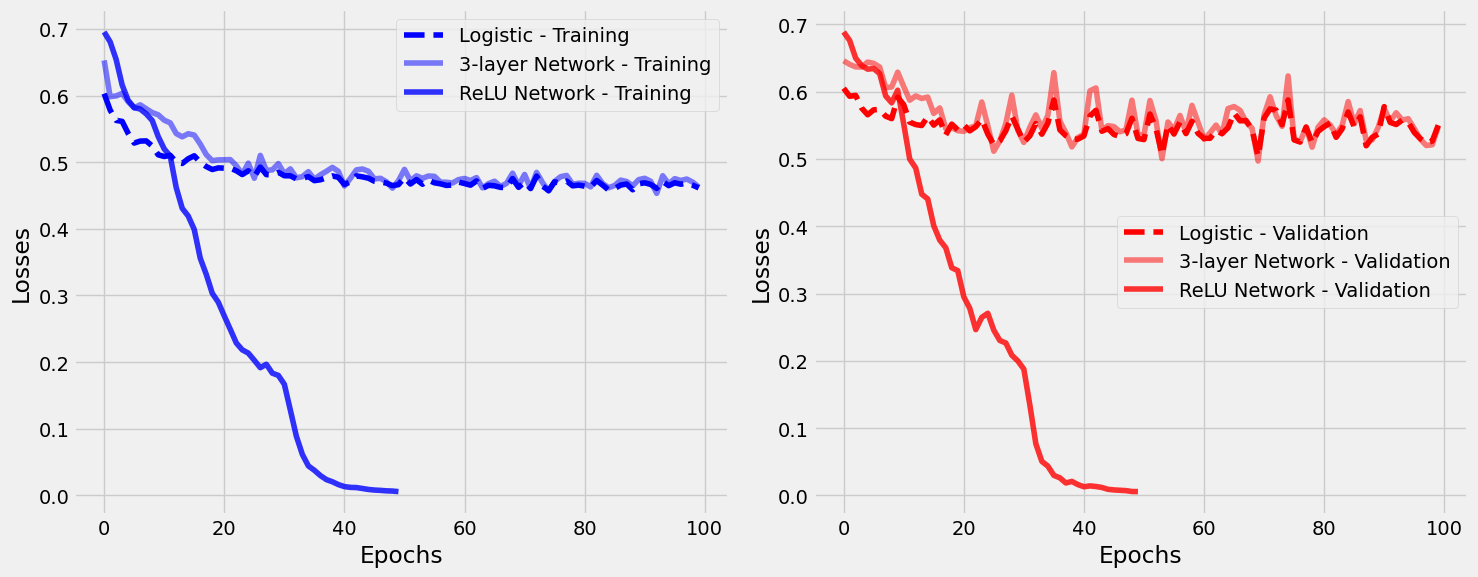

In [251]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)
fig

`激活函数`通过`打破`逻辑斯蒂回归的`等价性`，能够在最小化损失方面取得更好的结果

### Show Me the Math Again!

$$
\large
\begin{array}{rcccccccccccc}
\text{Hidden }\#0 & & & & & & & &
\underset{(5 \times 1)}{
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}}
&
=
&
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}
&
&
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}
\\
\text{Hidden }\#1 & & & &
\underset{(3 \times 1)}{
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}}
&
=
&
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}
&
&
\underbrace{
f_0
\underset{(5 \times 1)}{
\left(
\begin{bmatrix}
z_{00} \\
z_{01} \\
z_{02} \\
z_{03} \\
z_{04} \\
\end{bmatrix}
\right)}}_{\text{Activation #0}}
\\
\text{Output} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}
&
\underbrace{
f_1
\underset{(3 \times 1)}{
\left(
\begin{bmatrix}
z_{10} \\
z_{11} \\
z_{12} \\
\end{bmatrix}
\right)}}_{\text{Activation #1}}
\\
\hline
\text{substituting z's...} &
\underset{(1 \times 1)}{
\begin{bmatrix}
z_{2}
\end{bmatrix}}
&
=
&
\underbrace{
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T}_{20} & -\\
\end{bmatrix}}}_{\text{Output Layer}}
&
f_1
& &
\left(
\underbrace{
\underset{(3 \times 5)}{
\begin{bmatrix}
- & w^{T}_{10} & -\\
- & w^{T}_{11} & -\\
- & w^{T}_{12} & -\\
\end{bmatrix}}}_{\text{Hidden Layer #1}}
\right.
&
&
f_0
& &
\left(
\underbrace{
\underset{(5 \times 25)}{
\begin{bmatrix}
- & w^{T}_{00} & -\\
- & w^{T}_{01} & -\\
- & w^{T}_{02} & -\\
- & w^{T}_{03} & -\\
- & w^{T}_{04} & -
\end{bmatrix}}}_{\text{Hidden Layer #0}}
\right.
&
&
\left.
\left.
\underbrace{
\underset{(25 \times 1)}{
\begin{bmatrix}
x_0 \\
\vdots \\
x_{11} \\
\vdots \\
x_{24}
\end{bmatrix}}}_{\text{Inputs}}
\right)
\right)
\end{array}
$$

![1](fig/04_equivalence_deep_shallow_models_1.png)
![2](fig/04_activation_functions_break_equivalence_1.png)

## Putting It All Together

In [253]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [254]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    # If the total does not add up to one
    # divide every number by the total
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [255]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [256]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

IndexError: index 118 is out of bounds for dimension 0 with size 5

In [257]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [258]:
n_epochs = 50

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)